# Lab | Handling Data Imbalance in Classification Models


### Import the required libraries and modules that you would need.

In [1]:
!pip install pymysql

In [55]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### Read that data into Python and call the dataframe churnData.

In [3]:
churnData = pd.read_csv("files_for_lab/Customer-Churn.csv")

## Check the datatypes of all the columns in the data. 

You would see that the column TotalCharges is object type. Convert this column into numeric type using pd.to_numeric function.


In [4]:
churnData.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"], errors = 'coerce')

In [6]:
churnData["TotalCharges"].dtypes

dtype('float64')

### Check for null values in the dataframe. Replace the null values.

In [7]:
def checking_nulls(df):
    # This function shows which columns have null values and returns a df with only nulls
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            print ("The column ", c, " has ", null_count, " null values")
    nulls = df[df.isna().any(axis=1)]
    return nulls.head(3)

In [8]:
checking_nulls(churnData)

The column  TotalCharges  has  11  null values


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,Yes,No,Yes,Yes,Yes,No,Two year,52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,Yes,Yes,Yes,No,Yes,Yes,Two year,80.85,NaN,No


In [9]:
def replace_nulls_mean(df):
    # This function replaces null values with the mean of the column.
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            df[c].fillna((df[c].mean()), inplace=True)

In [10]:
replace_nulls_mean(churnData)

In [11]:
checking_nulls(churnData)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn


### Use the following features: tenure, SeniorCitizen, MonthlyCharges and TotalCharges:

In [12]:
y = pd.DataFrame(churnData["Churn"])

In [13]:
for c in churnData.columns:
    if c not in ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']:
        X = churnData.drop(c, axis = 1, inplace = True)

#### - Scale the features either by using normalizer or a standard scaler.

In [14]:
churnData.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15


#### - Scale the features either by using normalizer or a standard scaler.

In [15]:
transformer = Normalizer().fit(churnData)
transformer
churnData_norm = transformer.transform(churnData)
churnData_norm = pd.DataFrame(churnData_norm, columns=churnData.columns, index=churnData.index)

In [16]:
churnData.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15


#### - Split the data into a training set and a test set.

In [17]:
X = churnData

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### - Fit a logistic regression model on the training data.

In [19]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

#### - Check the accuracy on the test data.

In [20]:
logreg.score(X_test, y_test)

0.7825099375354913

### Managing imbalance in the dataset

#### - Check for the imbalance.

In [39]:
def cat_exploration(df):
    # This function displays the proportion of each value type for each categorical column and its countplot
    cat = df.select_dtypes('object')
    for c in cat.columns:
        sns.set_style("darkgrid")
        print(c)
        print(cat[c].value_counts(normalize=True).mul(100).round(1))
        print(cat[c].value_counts())
        fig, axes = plt.subplots(1, 1, figsize=(7, 4))
        sns.countplot(cat[c], color = 'gray')
        plt.show()

Churn
No     73.5
Yes    26.5
Name: Churn, dtype: float64
No     5174
Yes    1869
Name: Churn, dtype: int64


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


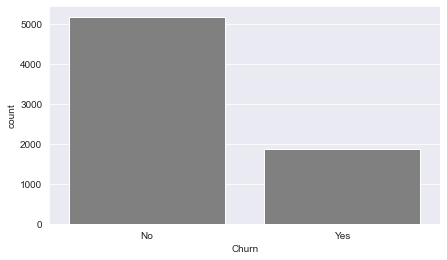

In [40]:
cat_exploration(y)

#### - Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.

Upsampling 

In [46]:
data_up = pd.concat([X_train, y_train], axis=1)

Yes = data_up[data_up['Churn'] == 'Yes'].sample(5174, replace=True) 
No = data_up[data_up['Churn'] == 'No'].sample(5174, replace=True)

upsampled_train = pd.concat([Yes, No]).sample(frac=1)
X_up_train = upsampled_train.drop("Churn", axis = 1)
y_up_train = upsampled_train["Churn"]

In [47]:
logreg.fit(X_up_train, y_up_train)
logreg.score(X_test, y_test)

0.6802952867688813

SMOTE

In [ ]:
X_train_sm = X_train.copy()
y_train_sm = y_train.copy()

In [27]:
smote = SMOTE()

X_train_sm, y_train_sm = smote.fit_resample(X_train_sm, y_train_sm)

Churn
No       3876
Yes      3876
dtype: int64

In [48]:
logreg.fit(X_train_sm, y_train_sm)
logreg.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7149346961953436

Downsampling

In [49]:
data_dw = pd.concat([X_train, y_train], axis=1)

Yes = data_dw[data_dw['Churn'] == 'Yes'].sample(1869, replace=True) 
No = data_dw[data_dw['Churn'] == 'No'].sample(1869, replace=True)

downsampled_train = pd.concat([Yes, No]).sample(frac=1)
X_dw_train = downsampled_train.drop("Churn", axis = 1)
y_dw_train = downsampled_train["Churn"]

In [51]:
logreg.fit(X_dw_train, y_dw_train)
logreg.score(X_test, y_test)

0.7018739352640545

Tomeklinks

In [52]:
X_train_tl = X_train.copy()
y_train_tl = y_train.copy()

In [56]:
tl = TomekLinks('majority')

X_train_tl, y_train_tl = tl.fit_resample(X_train_tl, y_train_tl)

/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/lib/python3.9/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [57]:
logreg.fit(X_train_tl, y_train_tl)
logreg.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7597955706984668